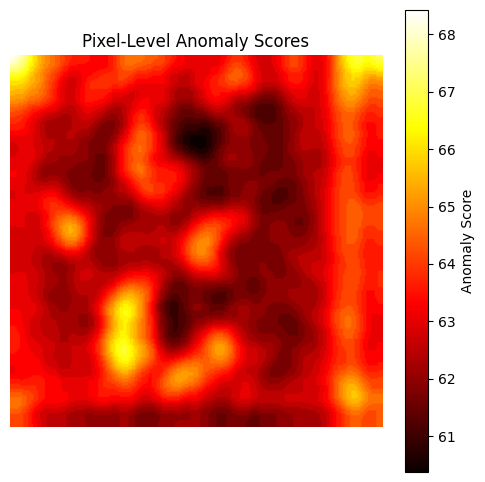

In [21]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

class BurgerData(Dataset):
    def __init__(self, imgSize: int, stride: int, image_folder: str, transform=None) -> None:
        super().__init__()

        self.imgSize = imgSize
        self.stride = stride
        self.image_folder = image_folder
        self.transform = transform

        # Assuming there is only one image in the folder
        self.image_path = None
        for f in os.listdir(image_folder):
            if f.endswith(('.png', '.jpg', '.jpeg')):
                self.image_path = os.path.join(image_folder, f)
                break

        if self.image_path is None:
            raise FileNotFoundError(f"No image found in {image_folder}")

    def __len__(self) -> int:
        return 1  # Only one image
    
    def __getitem__(self, index) -> torch.Tensor:  
        if index != 0:
            raise IndexError("Index out of range for single-image dataset")

        img = Image.open(self.image_path).convert("RGB")  # Ensure the image is RGB

        if self.transform:
            img_tensor = self.transform(img)
        else:
            raise ValueError("Transform is not provided. Please provide a valid transform.")
            
        return img_tensor  # Return the transformed image tensor


if __name__ == "__main__":
    mean = [0.6047, 0.6183, 0.5254]
    std = [0.2732, 0.2820, 0.2739]
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Dataset for a single image
    data = BurgerData(imgSize=256, stride=256, image_folder="/home/shn/data/Anomalies/spalsh", transform=transform)

    # Load the pre-trained model
    model = torch.load('white_with_edges448s')
    model.eval()

    # Retrieve the single image
    img_tensor = data[0].unsqueeze(0)  # Add a batch dimension

    # Predict anomaly scores
    img_lvl_anom_score, pxl_lvl_anom_score = model.predict(img_tensor)

    # Visualize pixel-level anomaly scores
    plt.figure(figsize=(6, 6))
    if isinstance(pxl_lvl_anom_score, torch.Tensor):
        pxl_lvl_anom_score = pxl_lvl_anom_score.squeeze().detach().cpu().numpy()

    plt.imshow(pxl_lvl_anom_score, cmap="hot")  # Use a heatmap (e.g., "hot", "viridis", etc.)
    plt.colorbar(label="Anomaly Score")
    plt.title("Pixel-Level Anomaly Scores")
    plt.axis("off")
    plt.show()
